In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayaroshevskiy/downsampled-imagenet-64x64")
print("Path to dataset files:", path)

/Users/igor.varha/miniconda3/envs/samp_hum_home/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/igor.varha/.cache/kagglehub/datasets/ayaroshevskiy/downsampled-imagenet-64x64/versions/1


In [2]:
from pathlib import Path

train_path = Path(path)/'train_64x64'/'train_64x64'
test_path = Path(path)/'valid_64x64/valid_64x64'
train_dataset_p = "tr_dataset.pt"
test_dataset_p = "te_dataset.pt"


In [3]:
from torch.utils.data import DataLoader
from image_toolkit.data_processor import FragmentDataset

test_dataset = FragmentDataset(test_path,limit=100, augment=False)

dataloader_test = DataLoader(test_dataset, batch_size=10, shuffle=True)

  0%|          | 99/49999 [00:00<00:42, 1169.81it/s]


In [103]:
from image_toolkit.nets import TransformerPatchCluster
import torch

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

model = TransformerPatchCluster(embed_dim=256,nhead=8,device=DEVICE,num_layers=10).to(DEVICE) #0.72

model.load_weights("best_ttc_256_8_10_ARI76.5(100K)/best_model_epoch_15.pth")


model.eval()

Weights loaded from best_ttc_256_8_10_ARI76.5(100K)/best_model_epoch_15.pth


/Users/igor.varha/PycharmProjects/samp_hum_home/image_toolkit/nets.py:299: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location=s

TransformerPatchCluster(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

CCluster the test set and save the results

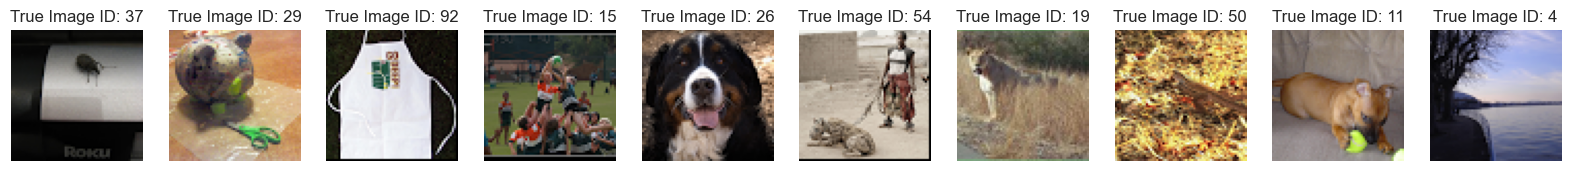

In [128]:
#cluster 1 batch and plot it
from sklearn.cluster import AgglomerativeClustering,KMeans

import matplotlib.pyplot as plt


batch,labels = next(iter(dataloader_test))

all_images = [ test_dataset.get_full_image(idx) for idx in labels]
B, N, C, H, W = batch.shape
true_labels = labels.numpy().repeat(N)
batch = batch.view(B * N, C, H, W)
embeddings = model(batch.to(DEVICE))
embeddings = embeddings.cpu().detach().numpy()
cluster = AgglomerativeClustering(n_clusters=10).fit_predict(embeddings)
#cluster = KMeans(n_clusters=10).fit_predict(embeddings)
# plot all images
fig, ax = plt.subplots(1, len(all_images), figsize=(20, 20))
for i, image in enumerate(all_images):
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].axis('off')
    ax[i].set_title(f"True Image ID: {labels[i]}")

plt.show()




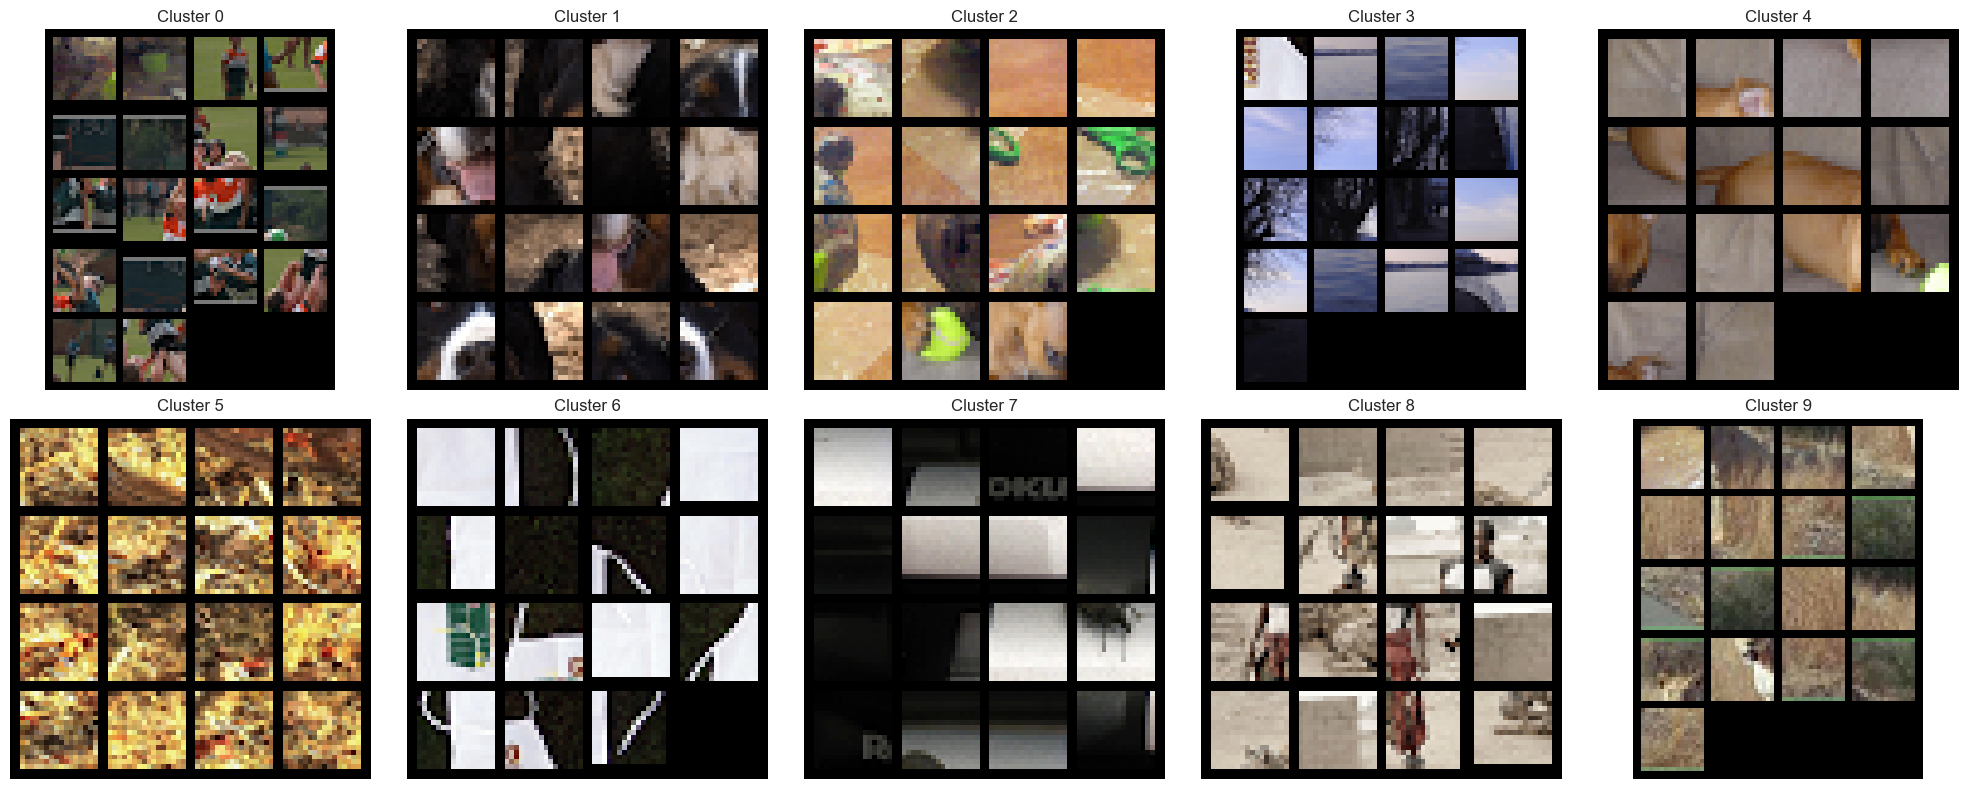

In [129]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Create 2 rows, 5 columns
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()  # Flatten to index easily

for cluster_id in range(10):
    indices = [i for i, c in enumerate(cluster) if c == cluster_id]
    if not indices:
        axs[cluster_id].axis('off')
        continue

    clustered_patches = batch[indices].cpu()

    grid = vutils.make_grid(clustered_patches, nrow=4, padding=2, normalize=True)
    axs[cluster_id].imshow(grid.permute(1, 2, 0))
    axs[cluster_id].axis('off')
    axs[cluster_id].set_title(f"Cluster {cluster_id}")

plt.tight_layout()
plt.show()

/Users/igor.varha/miniconda3/envs/samp_hum_home/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/h4/q7bcqz290p5dmmm6t1r2t72r0000gp/T/ipykernel_95922/515913880.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)  # or 'tab20' if >10


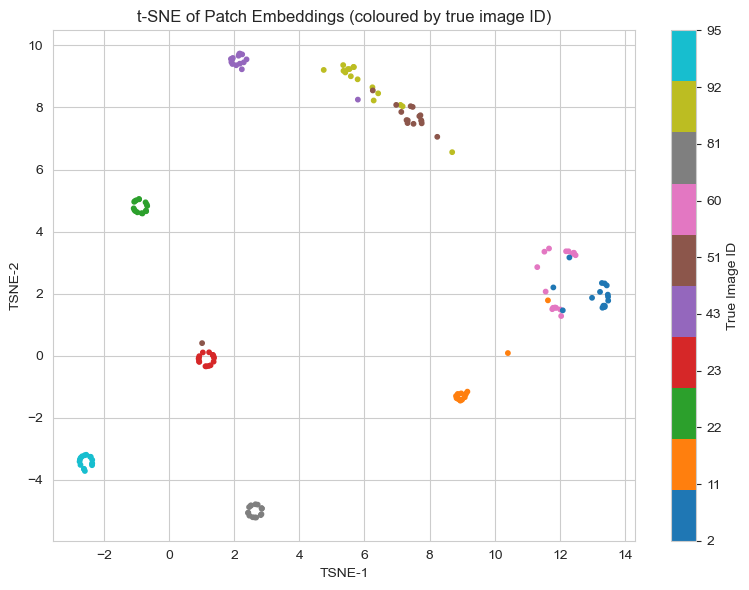

In [119]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

unique_labels = np.unique(true_labels)
n_classes = len(unique_labels)

# Map true_labels to 0...n_classes-1
label_map = {label: i for i, label in enumerate(unique_labels)}
label_ids = np.array([label_map[l] for l in true_labels])

# Plot with discrete colormap
cmap = plt.cm.get_cmap('tab10', n_classes)  # or 'tab20' if >10
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label_ids, cmap=cmap, s=10)

# Add colorbar with actual label ticks
cbar = plt.colorbar(scatter, ticks=np.arange(n_classes))
cbar.ax.set_yticklabels(unique_labels)
cbar.set_label("True Image ID")

ax.set_title("t-SNE of Patch Embeddings (coloured by true image ID)")
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")
plt.tight_layout()
plt.show()

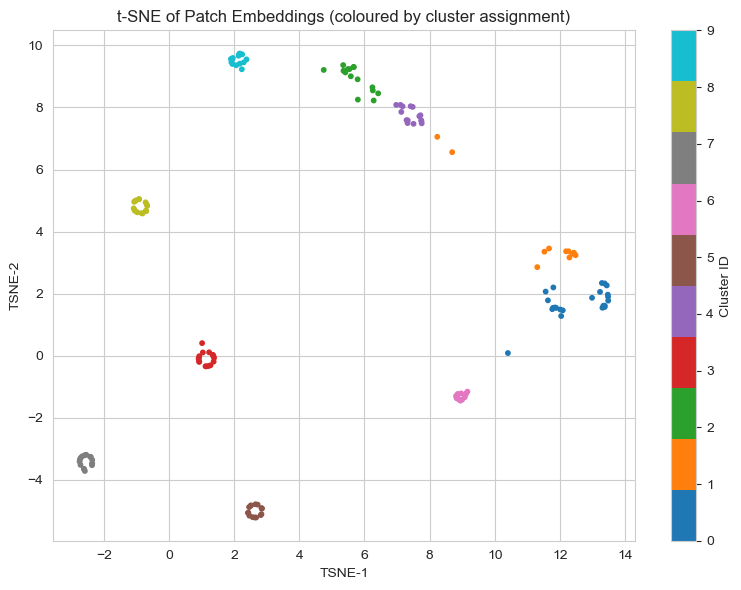

In [121]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster, cmap='tab10', s=10)
plt.colorbar(scatter, label="Cluster ID")
plt.title("t-SNE of Patch Embeddings (coloured by cluster assignment)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()

In [45]:
true_labels

array([85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 47,
       47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 63, 63,
       63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 61, 61, 61,
       61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 99, 99, 99, 99,
       99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 95, 95, 95, 95, 95,
       95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 94, 94, 94, 94, 94, 94,
       94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 84, 84, 84, 84, 84, 84, 84,
       84, 84, 84, 84, 84, 84, 84, 84, 84, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 56, 56, 56, 56, 56, 56, 56, 56, 56,
       56, 56, 56, 56, 56, 56, 56])